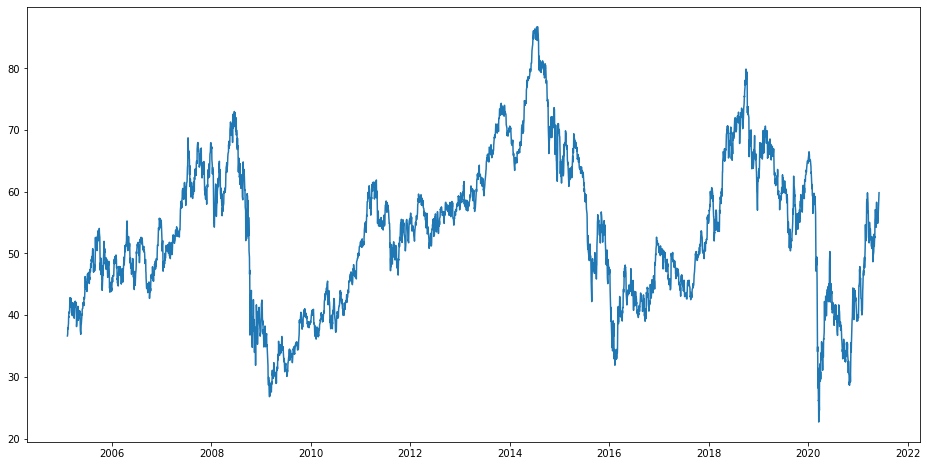

In [9]:
#import packages
import pandas as pd
import numpy as np
! pip install pmdarima
#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('/content/drive/MyDrive/8_semestr/diplom/COP.csv')

#print the head
df.head()
splitter=3950
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [10]:
import pmdarima as pm

data = df.sort_index(ascending=True, axis=0)

train = data[:splitter]
valid = data[splitter:]

training = train['Close']
validation = valid['Close']

model = pm.auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=18.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=14115.516, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12996.441, Time=1.59 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=11.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=14115.341, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=12578.500, Time=3.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=56.70 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=18.48 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=12588.709, Time=2.22 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=12580.449, Time=4.31 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=12580.445, Time=6.68 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=12578.446, Time=3.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=12996.401, Time=1.60 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=43.68 sec
 ARIMA(0,1,1)(1,1,1)[12]      

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [11]:
forecast = model.predict(n_periods=len(data)-splitter)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [12]:
from sklearn.metrics import r2_score
print(r2_score(np.array(valid['Close']), np.array(forecast['Prediction'])))
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
# rms

-3.145624951956532


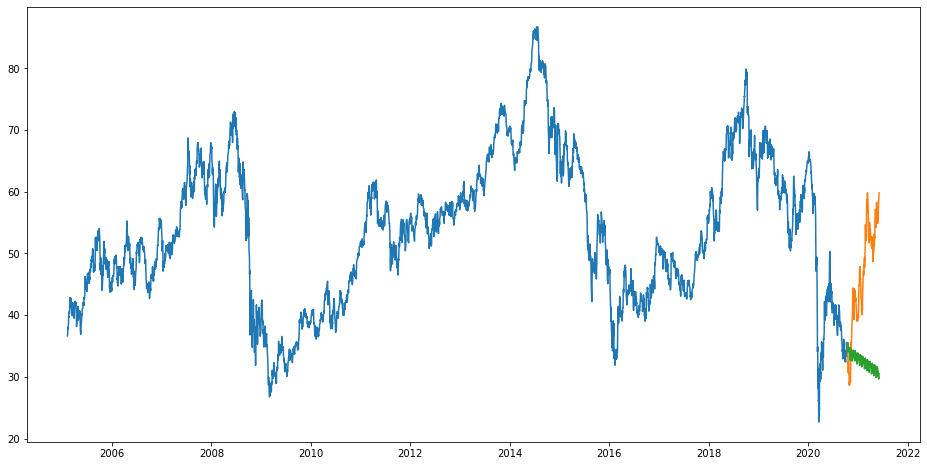

In [13]:
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

In [14]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:splitter]
valid = new_data[splitter:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
#rmse
forecast_valid = forecast['yhat'][splitter:]
print(r2_score(np.array(valid['y']),np.array(forecast_valid)))
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

-0.3465110938129674


9.739280510136837

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



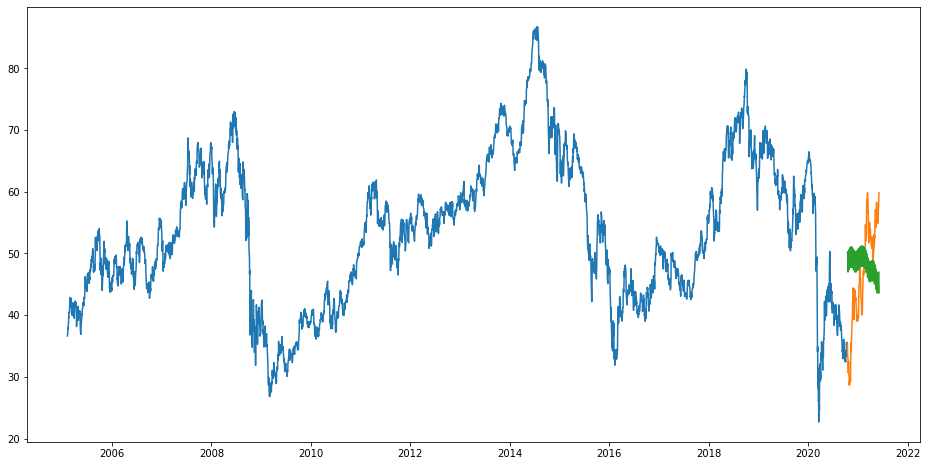

In [16]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.figure(figsize=(16,8))
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

In [17]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:splitter,:]
valid = dataset[splitter:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x_train, y_train, epochs = 100, batch_size = 150)
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(LSTM(units=50))
# model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


Epoch 1/50
122/122 [==============================] - 36s 61ms/step - loss: 0.0327
Epoch 2/50
122/122 [==============================] - 7s 60ms/step - loss: 0.0053
Epoch 3/50
122/122 [==============================] - 7s 60ms/step - loss: 0.0045
Epoch 4/50
122/122 [==============================] - 7s 61ms/step - loss: 0.0039
Epoch 5/50
122/122 [==============================] - 7s 61ms/step - loss: 0.0038
Epoch 6/50
122/122 [==============================] - 7s 61ms/step - loss: 0.0032
Epoch 7/50
122/122 [==============================] - 7s 61ms/step - loss: 0.0032
Epoch 8/50
122/122 [==============================] - 7s 60ms/step - loss: 0.0028
Epoch 9/50
122/122 [==============================] - 7s 61ms/step - loss: 0.0029
Epoch 10/50
122/122 [==============================] - 7s 60ms/step - loss: 0.0025
Epoch 11/50
122/122 [==============================] - 7s 61ms/step - loss: 0.0026
Epoch 12/50
122/122 [==============================] - 7s 61ms/step - loss: 0.0022
Epoch 13/50


In [18]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
# print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test)


[[[0.2842877 ]
  [0.27757838]
  [0.27476983]
  ...
  [0.20159151]
  [0.19051335]
  [0.18505225]]

 [[0.27757838]
  [0.27476983]
  [0.26681229]
  ...
  [0.19051335]
  [0.18505225]
  [0.19862696]]

 [[0.27476983]
  [0.26681229]
  [0.25417379]
  ...
  [0.18505225]
  [0.19862696]
  [0.17319394]]

 ...

 [[0.5634264 ]
  [0.54969575]
  [0.57341234]
  ...
  [0.51271646]
  [0.51599315]
  [0.55546885]]

 [[0.54969575]
  [0.57341234]
  [0.57980966]
  ...
  [0.51599315]
  [0.55546885]
  [0.56670309]]

 [[0.57341234]
  [0.57980966]
  [0.56982365]
  ...
  [0.55546885]
  [0.56670309]
  [0.57419254]]]


In [19]:
closing_price = model.predict(X_test)
print(closing_price.shape)
closing_price = scaler.inverse_transform(closing_price)

(160, 1)


In [20]:
print(r2_score(valid,closing_price))
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.8994276884170642


2.6617123684790682

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



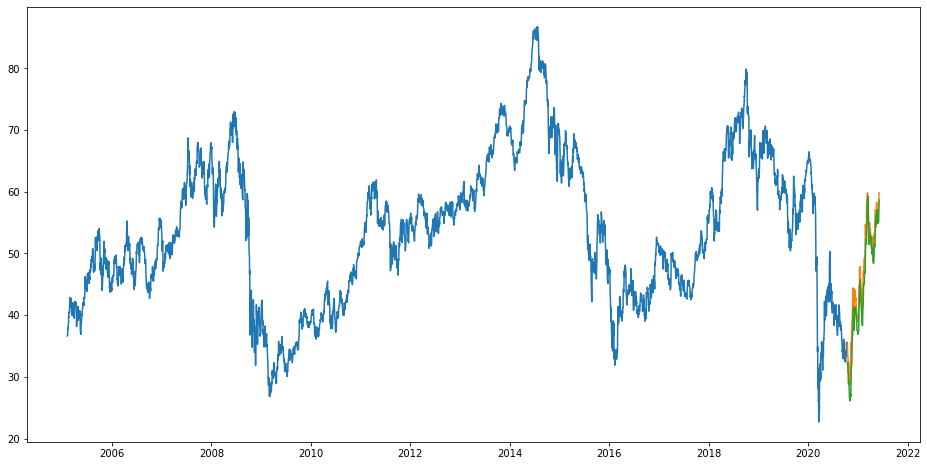

In [21]:
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [23]:
from keras.layers import GRU
from keras.optimizers import SGD

my_GRU_model = Sequential()
# First GRU layer with Dropout regularisation
my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# Second GRU layer
my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
my_GRU_model.add(Dropout(0.2))

# Third GRU layer
my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# Fourth GRU layer
my_GRU_model.add(GRU(units=50, activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# The output layer
my_GRU_model.add(Dense(units=1))
# Compiling the RNN
my_GRU_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
my_GRU_model.fit(x_train,y_train,epochs=100,batch_size=150, verbose=1)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predictions = my_GRU_model.predict(X_test)
GRU_predictions = scaler.inverse_transform(GRU_predictions)

Epoch 1/100
26/26 [==============================] - 8s 62ms/step - loss: 0.1074
Epoch 2/100
26/26 [==============================] - 2s 62ms/step - loss: 0.0283
Epoch 3/100
26/26 [==============================] - 2s 63ms/step - loss: 0.0160
Epoch 4/100
26/26 [==============================] - 2s 63ms/step - loss: 0.0073
Epoch 5/100
26/26 [==============================] - 2s 63ms/step - loss: 0.0035
Epoch 6/100
26/26 [==============================] - 2s 63ms/step - loss: 0.0033
Epoch 7/100
26/26 [==============================] - 2s 64ms/step - loss: 0.0030
Epoch 8/100
26/26 [==============================] - 2s 63ms/step - loss: 0.0028
Epoch 9/100
26/26 [==============================] - 2s 63ms/step - loss: 0.0026
Epoch 10/100
26/26 [==============================] - 2s 62ms/step - loss: 0.0026
Epoch 11/100
26/26 [==============================] - 2s 61ms/step - loss: 0.0023
Epoch 12/100
26/26 [==============================] - 2s 62ms/step - loss: 0.0024
Epoch 13/100
26/26 [=====

In [24]:
# print(GRU_predictions)
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], GRU_predictions, squared=False)
print(r2_score(valid["Close"],GRU_predictions))
# print(rms)
# print(GRU_predictions[100:])
# print(valid)
# print(GRU_predictions.shape)
rms


0.8741376338003426


2.977623975441205

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



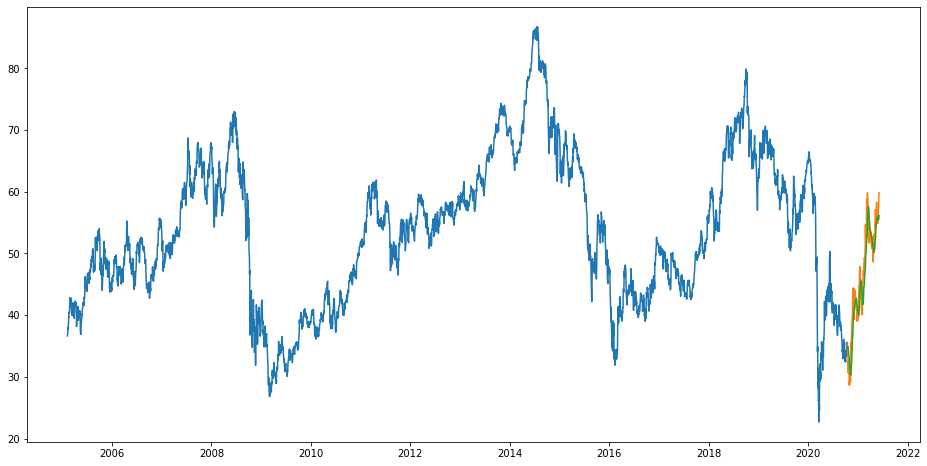

In [26]:
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = GRU_predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

Real prediiction with LSTM

[0.28428769591862385, 0.27757838110225047, 0.27476983071400124, 0.2668122868836859, 0.25417379453350614, 0.26946479109175253, 0.23357775835301103, 0.229676993924887, 0.21906691468038958, 0.23357775835301103, 0.23950693588681743, 0.23997501201513455, 0.2438757764432587, 0.26478387377800355, 0.26587608781787836, 0.2963020659603037, 0.2802309321194904, 0.2831954974818069, 0.2813231461593651, 0.27555003040879916, 0.26493995116430175, 0.25120922917118965, 0.24169136396656682, 0.2527695193393816, 0.25245744258207387, 0.23232954494212682, 0.2415353645955574, 0.24512405226637374, 0.23747852278113518, 0.22608830625407056, 0.21391793684138133, 0.20783275993656553, 0.20580434683088328, 0.17771884294838997, 0.18396003482727302, 0.1599313103469711, 0.16289593812151865, 0.16929317618058431, 0.17366201673702558, 0.19363397741819394, 0.20939303450169972, 0.2059603462018928, 0.18239976026213894, 0.18146354559327366, 0.1599313103469711, 0.17054138959146853, 0.1721017421718914, 0.1722577415429008, 0.1527

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



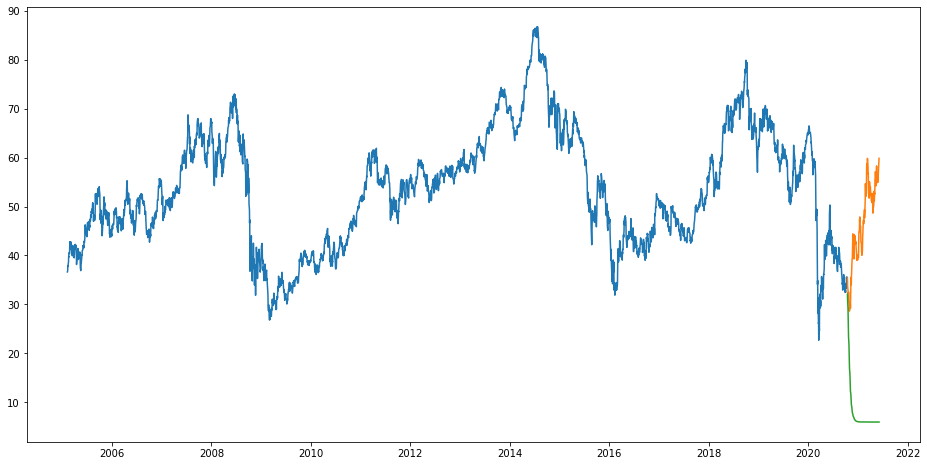

In [28]:
from numpy import array
x_input=scaled_data[splitter-60:splitter,:].reshape(1,-1)

temp_input1=list(x_input)
temp_input1=temp_input1[0].tolist()
print((temp_input1))
temp2=np.array(temp_input1)
lst_output1=[]
n_steps1=60
i=0
while(i<len(scaled_data)-splitter):
    
    if(len(temp_input1)>60):
        #print(temp_input)
        x_input=np.array(temp_input1[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps1, 1))
        #print(x_input)
        yhat1 = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat1))
        temp_input1.extend(yhat1[0].tolist())
        temp_input1=temp_input1[1:]
        #print(temp_input)
        lst_output1.extend(yhat1.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps1,1))
        yhat1 = model.predict(x_input, verbose=0)
        print(yhat1[0])
        temp_input1.extend(yhat1[0].tolist())
        print(len(temp_input1))
        lst_output1.extend(yhat1.tolist())
        i=i+1
    

print("lst:", lst_output1)
predictions = scaler.inverse_transform(lst_output1)

from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], predictions, squared=False)
print(r2_score(valid["Close"],predictions))
rms
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [29]:
from numpy import array
x_input=scaled_data[splitter-60:splitter,:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print((temp_input))
temp2=np.array(temp_input)
# print(scaler.inverse_transform(temp2.reshape(-1,1)))

[0.28428769591862385, 0.27757838110225047, 0.27476983071400124, 0.2668122868836859, 0.25417379453350614, 0.26946479109175253, 0.23357775835301103, 0.229676993924887, 0.21906691468038958, 0.23357775835301103, 0.23950693588681743, 0.23997501201513455, 0.2438757764432587, 0.26478387377800355, 0.26587608781787836, 0.2963020659603037, 0.2802309321194904, 0.2831954974818069, 0.2813231461593651, 0.27555003040879916, 0.26493995116430175, 0.25120922917118965, 0.24169136396656682, 0.2527695193393816, 0.25245744258207387, 0.23232954494212682, 0.2415353645955574, 0.24512405226637374, 0.23747852278113518, 0.22608830625407056, 0.21391793684138133, 0.20783275993656553, 0.20580434683088328, 0.17771884294838997, 0.18396003482727302, 0.1599313103469711, 0.16289593812151865, 0.16929317618058431, 0.17366201673702558, 0.19363397741819394, 0.20939303450169972, 0.2059603462018928, 0.18239976026213894, 0.18146354559327366, 0.1599313103469711, 0.17054138959146853, 0.1721017421718914, 0.1722577415429008, 0.1527

In [30]:
lst_output=[]
n_steps=60
i=0
while(i<len(scaled_data)-splitter):
    
    if(len(temp_input)>60):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = my_GRU_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = my_GRU_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    



[0.18754616]
61
1 day input [0.27757838 0.27476983 0.26681229 0.25417379 0.26946479 0.23357776
 0.22967699 0.21906691 0.23357776 0.23950694 0.23997501 0.24387578
 0.26478387 0.26587609 0.29630207 0.28023093 0.2831955  0.28132315
 0.27555003 0.26493995 0.25120923 0.24169136 0.25276952 0.25245744
 0.23232954 0.24153536 0.24512405 0.23747852 0.22608831 0.21391794
 0.20783276 0.20580435 0.17771884 0.18396003 0.15993131 0.16289594
 0.16929318 0.17366202 0.19363398 0.20939303 0.20596035 0.18239976
 0.18146355 0.15993131 0.17054139 0.17210174 0.17225774 0.15275392
 0.1586831  0.15228584 0.1622718  0.18115148 0.16586049 0.18193168
 0.20065531 0.19441411 0.20159151 0.19051335 0.18505225 0.18754616]
1 day output [[0.18955132]]
2 day input [0.27476983 0.26681229 0.25417379 0.26946479 0.23357776 0.22967699
 0.21906691 0.23357776 0.23950694 0.23997501 0.24387578 0.26478387
 0.26587609 0.29630207 0.28023093 0.2831955  0.28132315 0.27555003
 0.26493995 0.25120923 0.24169136 0.25276952 0.25245744 0.23

In [31]:
# print(lst_output)
predictions = scaler.inverse_transform(lst_output)
# print(predictions)
# lst_output=np.array(predictions)
# print(predictions.shape)
# print((lst_output))
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], predictions, squared=False)
print(r2_score(valid["Close"],predictions))
rms

-1.006769615011831


11.889693655233575

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



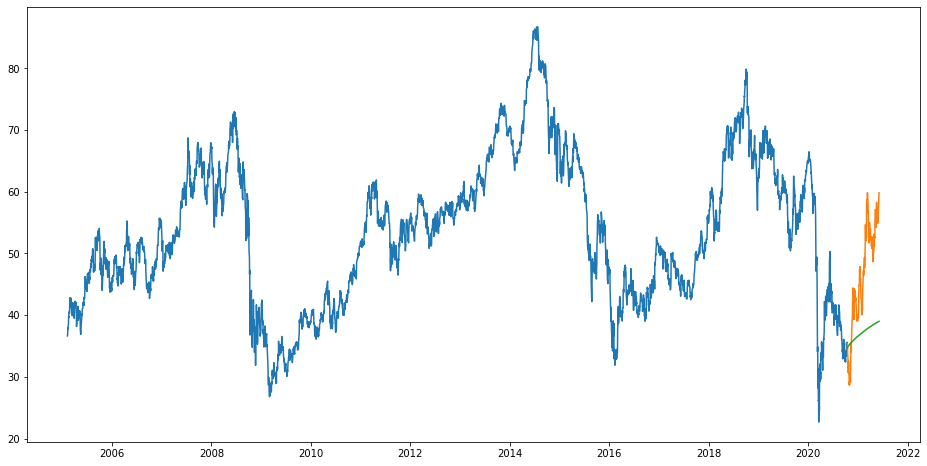

In [32]:
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])